In [1]:
import telegram

import numpy as np
import pandas as pd
import pandahouse as ph

from datetime import date, timedelta, datetime

import matplotlib.pyplot as plt
import seaborn as sns
import io

Подключаемся к базе данных и к Telegram-боту.

In [2]:
# данные для подключения к БД
connection = {...}

In [3]:
my_token = ...  # токен бота
bot = telegram.Bot(token=my_token) # получение доступа

chat_id = ...  # ID чата, в который будут отправляться отчеты

Извлекаем данные для отчета.

In [4]:
# Извлечение данных для текстового отчета по ленте новостей
query_fd = """
    SELECT
        uniq(user_id) AS DAU,
        countIf(action='view') AS views,
        countIf(action='like') AS likes,
        likes/views AS CTR
    FROM simulator_20250920.feed_actions
    WHERE toDate(time) = yesterday()
    GROUP BY toDate(time)
    """

data_fd = ph.read_clickhouse(query=query_fd, connection=connection)
data_fd

,DAU,views,likes,CTR
0,19572,744881,164565,0.220928


In [5]:
# Извлечение данных для текстового отчета по мессенджеру
query_msgr = """
    WITH
    send_data AS (
        SELECT
            user_id,
            COUNT(receiver_id) AS messages_sent
        FROM simulator_20250920.message_actions
        WHERE toDate(time) = yesterday()
        GROUP BY user_id
        )

    SELECT
        uniq(user_id) AS DAU,
        COUNT() AS total_messages_count,
        (SELECT AVG(messages_sent) FROM send_data) AS avg_messages_per_user
    FROM simulator_20250920.message_actions
    WHERE toDate(time) = yesterday()
    """

data_msgr = ph.read_clickhouse(query=query_msgr, connection=connection)
data_msgr

,DAU,total_messages_count,avg_messages_per_user
0,3747,32259,8.609287


In [6]:
# Извлечение данных для построение графиков по ленте новостей
query_feed = """
    SELECT
        uniq(user_id) AS DAU,
        countIf(action='view') AS views,
        countIf(action='like') AS likes,
        likes/views AS CTR,
        toDate(time) AS date
    FROM simulator_20250920.feed_actions
    WHERE toDate(time) BETWEEN (today() - 7) AND yesterday()
    GROUP BY toDate(time)
    """

data_feed = ph.read_clickhouse(query=query_feed, connection=connection)
data_feed.head()

,DAU,views,likes,CTR,date
0,19593,622100,129435,0.208061,2025-11-22
1,20061,659099,132894,0.201630,2025-11-23
2,20400,590392,120249,0.203677,2025-11-24
3,20198,661020,139146,0.210502,2025-11-25
4,19878,719022,151952,0.211332,2025-11-26


In [7]:
# Извлечение данных для построения графиков по мессенджеру
query_messager = """
    WITH
    send_data AS (
        SELECT
            uniq(user_id) AS users,
            COUNT(user_id) AS messages_sent,
            messages_sent / users AS avg_messages_per_user,
            toDate(time) AS date
        FROM simulator_20250920.message_actions
        WHERE toDate(time) BETWEEN (today() - 7) AND yesterday()
        GROUP BY toDate(time)
        ),
    messager_data AS (
        SELECT
            uniq(user_id) AS DAU,
            COUNT(user_id) AS total_messages_count,
            toDate(time) AS date
        FROM simulator_20250920.message_actions
        WHERE toDate(time) BETWEEN (today() - 7) AND yesterday()
        GROUP BY toDate(time)
        )

    SELECT
        messager_data.DAU AS DAU,
        messager_data.total_messages_count AS total_messages_count,
        send_data.avg_messages_per_user AS avg_messages_per_user,
        messager_data.date AS date
    FROM messager_data LEFT JOIN send_data USING(date)
    """

data_messager = ph.read_clickhouse(query=query_messager, connection=connection)
data_messager.head()

,DAU,total_messages_count,avg_messages_per_user,date
0,1739,12899,7.417481,2025-11-22
1,2540,12899,5.078346,2025-11-24
2,1736,12900,7.430876,2025-11-26
3,3747,32259,8.609287,2025-11-28
4,1662,12901,7.762335,2025-11-23


Строим графики.

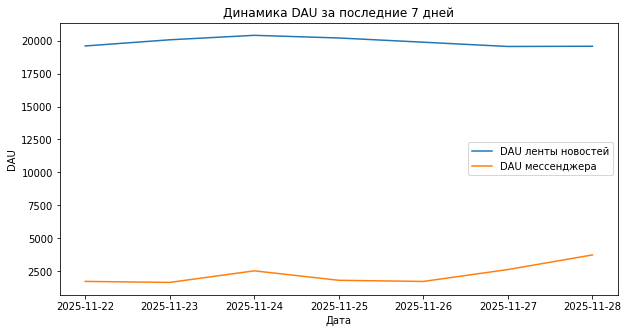

In [8]:
# DAU
plt.figure(figsize=(10, 5))
sns.lineplot(x=data_feed['date'], y=data_feed['DAU'], label='DAU ленты новостей')
sns.lineplot(x=data_messager['date'], y=data_messager['DAU'], label='DAU мессенджера')
plt.title('Динамика DAU за последние 7 дней')
plt.xlabel('Дата')
plt.ylabel('DAU')
plt.legend()
plt.show()

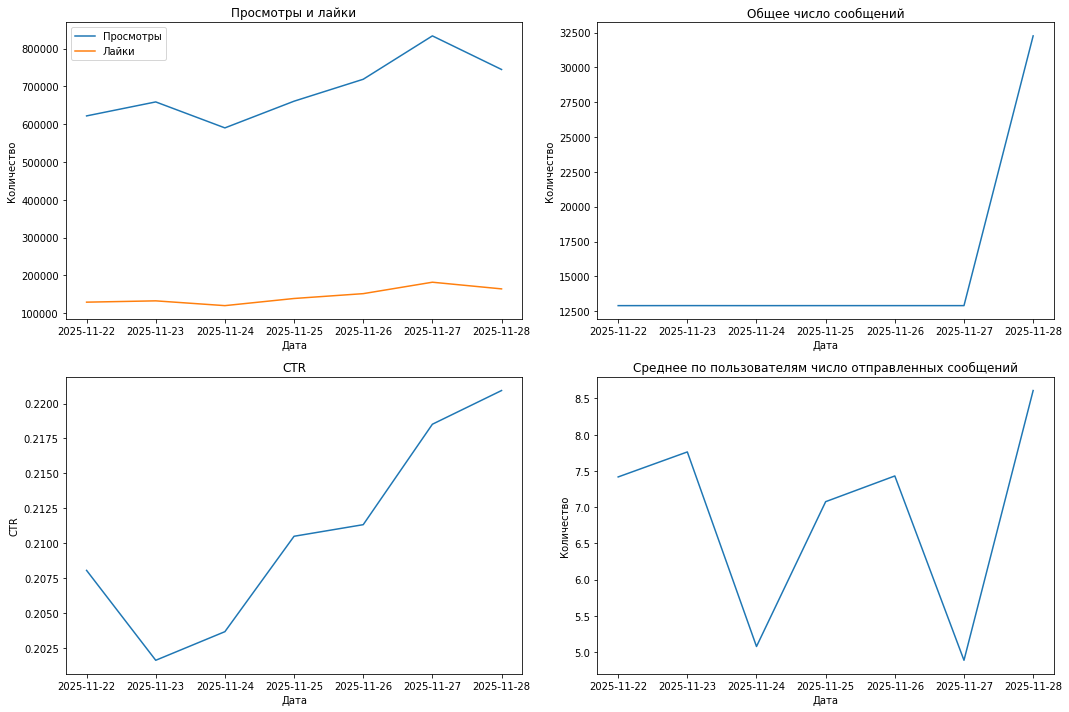

In [9]:
# Остальные метрики
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# график 1: Лайки и просмотры
sns.lineplot(x=data_feed['date'], y=data_feed['views'], ax=axes[0, 0], label='Просмотры')
sns.lineplot(x=data_feed['date'], y=data_feed['likes'], ax=axes[0, 0], label='Лайки')
axes[0, 0].set_title('Просмотры и лайки')
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Количество')

# график 2: CTR
sns.lineplot(x=data_feed['date'], y=data_feed['CTR'], ax=axes[1, 0])
axes[1, 0].set_title('CTR')
axes[1, 0].set_xlabel('Дата')
axes[1, 0].set_ylabel('CTR')

# график 3: Общее число сообщений
sns.lineplot(x=data_messager['date'], y=data_messager['total_messages_count'], ax=axes[0, 1])
axes[0, 1].set_title('Общее число сообщений')
axes[0, 1].set_xlabel('Дата')
axes[0, 1].set_ylabel('Количество')

# график 3: Среднее по пользователям число отправленных сообщений
sns.lineplot(x=data_messager['date'], y=data_messager['avg_messages_per_user'], ax=axes[1, 1])
axes[1, 1].set_title('Среднее по пользователям число отправленных сообщений')
axes[1, 1].set_xlabel('Дата')
axes[1, 1].set_ylabel('Количество')

plt.tight_layout()  # автоматический подгон отступов
plt.show()

А теперь отправляем отчет в Telegram.

In [10]:
# Отправка краткого отчета за вчера
message = f"Информация о метриках за вчера ({date.today() - timedelta(days=1)})\n\n" + \
    f"DAU ленты: {data_fd['DAU'].iloc[0]}\n" + \
    f"Количество просмотров: {data_fd['views'].iloc[0]}\nКоличество лайков: {data_fd['likes'].iloc[0]}\n" + \
    f"CTR: {data_fd['CTR'].iloc[0]: .4f}\n\n" + \
    f"DAU мессенджера: {data_msgr['DAU'].iloc[0]}\n" + \
    f"Общее число сообщений: {data_msgr['total_messages_count'].iloc[0]}\n" + \
    f"Среднее по пользователям число отправленных сообщений: {data_msgr['avg_messages_per_user'].iloc[0]: .2f}"

bot.sendMessage(chat_id=chat_id, text=message);

In [11]:
# Отправка графиков с динамикой метрик за последнюю неделю

# DAU
plt.figure(figsize=(20, 10))
sns.lineplot(x=data_feed['date'], y=data_feed['DAU'], label='DAU ленты новостей')
sns.lineplot(x=data_messager['date'], y=data_messager['DAU'], label='DAU мессенджера')
plt.title('Динамика DAU за последние 7 дней')
plt.xlabel('Дата')
plt.ylabel('DAU')
plt.legend()

plot_object = io.BytesIO()
plt.savefig(plot_object)
plot_object.seek(0)
plot_object.name = 'DAU.png'
plt.close()
bot.sendPhoto(chat_id=chat_id, photo=plot_object)

# Остальные метрики
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# график 1: Лайки и просмотры
sns.lineplot(x=data_feed['date'], y=data_feed['views'], ax=axes[0, 0], label='Просмотры')
sns.lineplot(x=data_feed['date'], y=data_feed['likes'], ax=axes[0, 0], label='Лайки')
axes[0, 0].set_title('Просмотры и лайки')
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Количество')

# график 2: CTR
sns.lineplot(x=data_feed['date'], y=data_feed['CTR'], ax=axes[1, 0])
axes[1, 0].set_title('CTR')
axes[1, 0].set_xlabel('Дата')
axes[1, 0].set_ylabel('CTR')

# график 3: Общее число сообщений
sns.lineplot(x=data_messager['date'], y=data_messager['total_messages_count'], ax=axes[0, 1])
axes[0, 1].set_title('Общее число сообщений')
axes[0, 1].set_xlabel('Дата')
axes[0, 1].set_ylabel('Количество')

# график 3: Среднее по пользователям число отправленных сообщений
sns.lineplot(x=data_messager['date'], y=data_messager['avg_messages_per_user'], ax=axes[1, 1])
axes[1, 1].set_title('Среднее по пользователям число отправленных сообщений')
axes[1, 1].set_xlabel('Дата')
axes[1, 1].set_ylabel('Количество')

plt.tight_layout()  # автоматический подгон отступов

plot_object = io.BytesIO()
plt.savefig(plot_object)
plot_object.seek(0)
plot_object.name = 'metrics.png'
plt.close()
bot.sendPhoto(chat_id=chat_id, photo=plot_object);